In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvp
from CSSS import CSSS
import time 
#import cvxopt as co
%matplotlib inline
print cvp.installed_solvers()

['ECOS_BB', 'SCS', 'ECOS', 'LS']


Import the data and drop rows with NAN.

In [4]:
df=pd.read_csv('input_data.csv')
df=df.dropna()

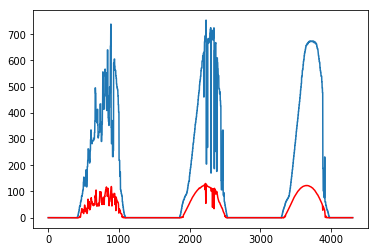

In [5]:
### Look at the solar proxies
plt.plot(df['Irradiance'])
plt.plot(df['IrradianceProxy'],'-r')

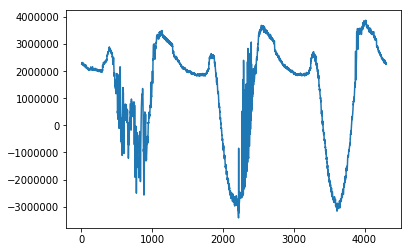

In [6]:
### Look at the total load shape
plt.plot(df['Real_Power_Total'])

# Simulate with regularization and additional constraint on solar

In [8]:
# Feeder-level Solar Disagg Using the New Class
N=len(df)
CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']/1000))).transpose(), alpha = 10, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff_l1',gamma=0)  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(np.array(df['IrradianceProxy']), alpha = 1, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.

# Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
# Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )
# Constraint Solar to be 0, when solar proxy is 0
irrProxy = df['IrradianceProxy']
idx0 = np.where(irrProxy<1)[0]
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'][idx0] == 0 )

start=time.time()
a=CSSS_solar.constructSolve('ECOS',True,500)
print("It took {} seconds in centralized CSSS".format(time.time()-start))
print(CSSS_solar.models['Solar']['theta'].value)
print(CSSS_solar.models['Load']['theta'].value)
    


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+09  4e-01  2e-04  1e+00  1e+05    ---    ---    1  1  - |  -  - 
 1  -1.047e+06  -1.047e+06  +1e+07  6e-03  2e-06  1e+01  2e+03  0.9880  1e-04   2  2  2 |  0  0
 2  -9.326e+05  -9.325e+05  +1e+07  3e-03  2e-06  4e+01  1e+03  0.2203  1e-01   4  3  3 |  0  0
 3  -3.990e+05  -3.990e+05  +2e+06  4e-04  4e-07  8e+01  3e+02  0.8210  6e-02   4  3  2 |  0  0
 4  -2.192e+05  -2.191e+05  +1e+06  2e-04  2e-07  5e+01  1e+02  0.5512  1e-01   5  4  4 |  0  0
 5  -8.443e+04  -8.439e+04  +3e+05  7e-05  4e-08  4e+01  3e+01  0.9595  2e-01   6  5  5 |  0  0
 6  +1.240e+05  +1.240e+05  +5e+04  1e-05  5e-09  8e+00  6e+00  0.8673  4e-02   2  3  3 |  0  0
 7  +1.570e+05  +1.570e+05  +9e+03  3e-06  3e-09  2e+00  1e+00  0.9535  1e-01   7  7  7 |  0  0
 8  +1.668e+05  +1.668e+05  +5e+02  2e-07  1e-

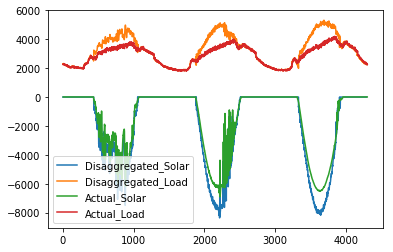

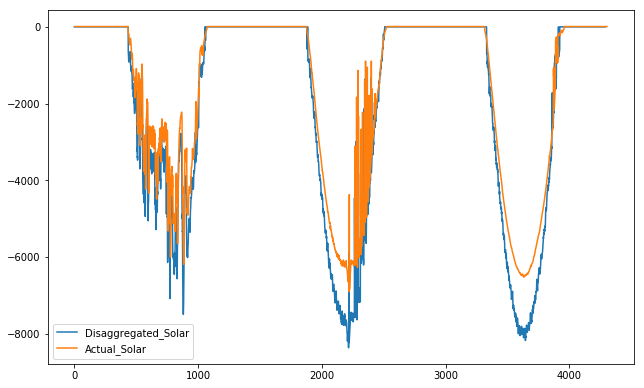

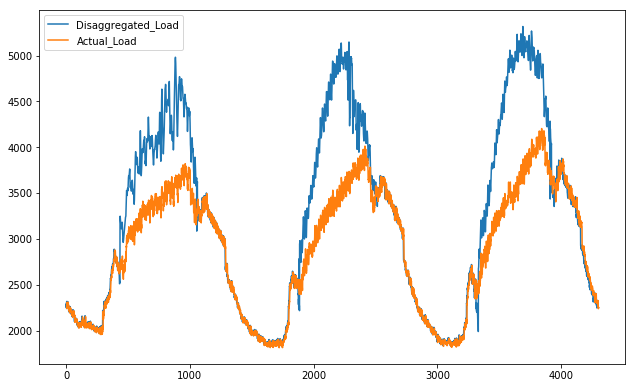

[354.71679858900904, 354.71679858900904, 354.7167985890091]


In [11]:
#print(CSSS_solar.models['Solar']['source'].value)
plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')
plt.plot(df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')
plt.legend()
plt.show()

plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
plt.legend()
plt.show()

plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
plt.legend()
plt.show()

# compute MAE
N = len(df)
solarAct = -1*df['Real_Power_PV']/1000
loadAct = df['Real_Power_Total']/1000+df['Real_Power_PV']/1000
solarDisag = []
for val in CSSS_solar.models['Solar']['source'].value:
    solarDisag.append(float(val))
loadDisag = []
for val in CSSS_solar.models['Load']['source'].value:
    loadDisag.append(float(val))

MAE = (np.sum(np.absolute(solarDisag-np.array(solarAct)))+np.sum(np.absolute(loadDisag-np.array(loadAct))))/(2*N)
MAE1 = (np.sum(np.absolute(solarDisag-np.array(solarAct))))/(N)
MAE2 = (np.sum(np.absolute(loadDisag-np.array(loadAct))))/(N)

print([MAE, MAE1, MAE2])


# No regularization; no additional constraint on solar

In [15]:
# Feeder-level Solar Disagg Using the New Class
N=len(df)
CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']/1000))).transpose(), alpha = 1, name = 'Load',costFunction='l2')  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(np.array(df['IrradianceProxy']), alpha = 0.5, name = 'Solar',costFunction='l2') ## Add a model for Solar: Irradiance Proxy Only as regressor.

# Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
# Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )

start=time.time()
a=CSSS_solar.constructSolve('ECOS',True,500)
print("It took {} seconds in centralized CSSS".format(time.time()-start))
print(CSSS_solar.models['Solar']['theta'].value)
print(CSSS_solar.models['Load']['theta'].value)

No regularization
No regularization

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+08  6e-01  2e-03  1e+00  2e+04    ---    ---    1  1  - |  -  - 
 1  +7.778e+02  +7.794e+02  +2e+06  5e-03  2e-05  2e+00  2e+02  0.9882  1e-04   2  1  1 |  0  0
 2  +2.249e+03  +2.251e+03  +5e+05  2e-03  6e-06  1e+00  6e+01  0.7001  7e-03   3  2  2 |  0  0
 3  -2.175e+02  -2.107e+02  +4e+05  9e-04  5e-06  7e+00  5e+01  0.3259  3e-01   3  2  2 |  0  0
 4  +7.291e+03  +7.294e+03  +8e+04  2e-04  1e-06  3e+00  9e+00  0.8473  5e-02   3  2  2 |  0  0
 5  +1.849e+04  +1.849e+04  +4e+04  8e-05  4e-07  2e+00  4e+00  0.5685  1e-01   3  3  3 |  0  0
 6  +1.994e+04  +1.994e+04  +2e+04  4e-05  2e-07  2e+00  2e+00  0.7401  2e-01   4  4  4 |  0  0
 7  +2.624e+04  +2.624e+04  +3e+03  7e-06  3e-08  4e-01  4e-01  0.8823  9e-02   4  4  5 |  0  0
 8  +2.854

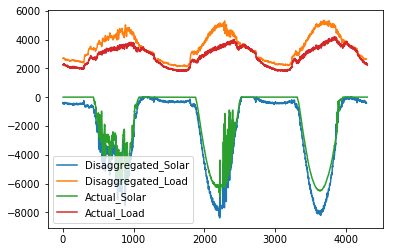

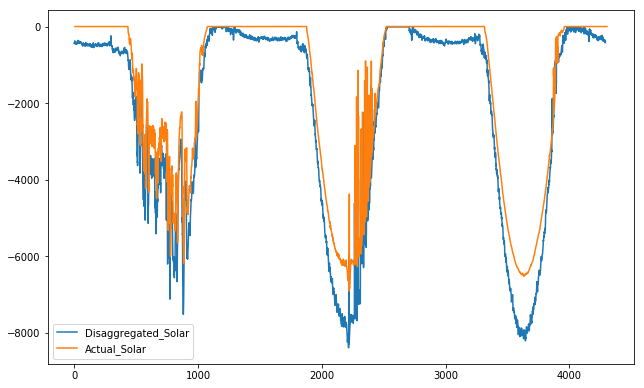

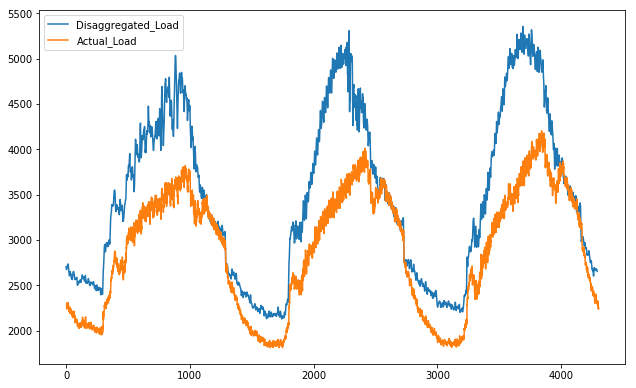

[577.267003196081, 577.267003196081, 577.2670031960811]


In [17]:
# print(CSSS_solar.models['Solar']['source'].value)
plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')
plt.plot(df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')
plt.legend()
plt.show()

plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
plt.legend()
plt.show()

plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
plt.legend()
plt.show()

# compute MAE
N = len(df)
solarAct = -1*df['Real_Power_PV']/1000
loadAct = df['Real_Power_Total']/1000+df['Real_Power_PV']/1000
solarDisag = []
for val in CSSS_solar.models['Solar']['source'].value:
    solarDisag.append(float(val))
loadDisag = []
for val in CSSS_solar.models['Load']['source'].value:
    loadDisag.append(float(val))

MAE = (np.sum(np.absolute(solarDisag-np.array(solarAct)))+np.sum(np.absolute(loadDisag-np.array(loadAct))))/(2*N)
MAE1 = (np.sum(np.absolute(solarDisag-np.array(solarAct))))/(N)
MAE2 = (np.sum(np.absolute(loadDisag-np.array(loadAct))))/(N)

print([MAE, MAE1, MAE2])


# Loop simulation for different regularization scaling factors for the load

In [58]:
# Loop simulation for different regularization scaling factors for the load
N=len(df)
regSourceMeth = 'diff_l2';
# gammaVec = np.concatenate((np.arange(0,3,0.1), np.arange(3,10,1))) # for l1 regularization
gammaVec = np.arange(0,1500,50) # for l2 regularization
cnt = 1
solarAct = -1*df['Real_Power_PV']/1000
loadAct = df['Real_Power_Total']/1000+df['Real_Power_PV']/1000
perf = []

CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(np.array(df['IrradianceProxy']), alpha = 0.1, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.

# Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
# Constraint Solar to be 0, when solar proxy is 0
irrProxy = df['IrradianceProxy']
idx0 = np.where(irrProxy<1)[0]
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'][idx0] == 0 )

for i in gammaVec:
    CSSS_solar.addSource(np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']/1000))).transpose(), alpha = 1, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource=regSourceMeth,gamma=i)  ## Add a model for Load:  Q + intercept term as regressor
    # Constrain Load to be >=0
    CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )

    start=time.time()
    a=CSSS_solar.constructSolve('ECOS',False,500)
    solarDisag = []
    for val in CSSS_solar.models['Solar']['source'].value:
        solarDisag.append(float(val))
    loadDisag = []
    for val in CSSS_solar.models['Load']['source'].value:
        loadDisag.append(float(val))
    #perf.append(np.linalg.norm(solarDisag-np.array(solarAct),2)+np.linalg.norm(loadDisag-np.array(loadAct),2))
    perf.append((np.sum(np.absolute(solarDisag-np.array(solarAct)))+np.sum(np.absolute(loadDisag-np.array(loadAct))))/(2*N))
    print("{}% done".format(round(100*cnt/len(gammaVec),2)))
    cnt+=1

np.save('load_regul_l2',perf)
np.save('gammaVec_l2',gammaVec)

3.0% done
6.0% done
10.0% done
13.0% done
16.0% done
20.0% done
23.0% done
26.0% done
30.0% done
33.0% done
36.0% done
40.0% done
43.0% done
46.0% done
50.0% done
53.0% done
56.0% done
60.0% done
63.0% done
66.0% done
70.0% done
73.0% done
76.0% done
80.0% done
83.0% done
86.0% done
90.0% done
93.0% done
96.0% done
100.0% done


[354.71652222 306.61921406 279.15811055 257.01524855 235.43127478
 213.4225806  191.1906713  168.47769696 144.68145723 120.31844077
  98.07478361  81.9297838   73.22200644  74.75247748  80.91771219
  82.67746953  83.73238463  84.80229537  85.88628014  86.97464575
  88.07487023  89.17620677  90.27526615  91.38919698  92.51920864
  93.66209501  94.82888265  96.0178141   97.21235227  97.60768846
  97.6076861   97.60768821  97.60768729  97.60768325  97.60768632
  97.6076881   97.60768727]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  4.  5.  6.  7.  8.
 9. ]
72.96503410232023


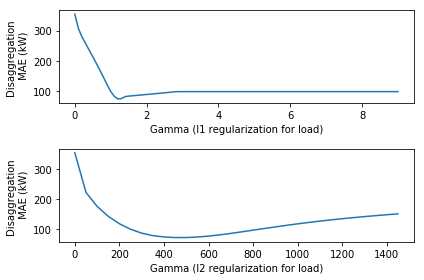

In [69]:
# alpha for load = 1, alpha for PV = 0.1 (loss function is l2 in both cases)
# No regul. for PV, only for load (2 cases: l1 and l2 norm for regularization)

gl1 = np.load('gammaVec_l1.npy')
perfl1 = np.load('load_regul_l1.npy')

gl2 = np.load('gammaVec_l2.npy')
perfl2 = np.load('load_regul_l2.npy')

print(perfl1)
print(gl1)
print(np.min(perfl2))

plt.figure(1)
plt.subplot(2,1,1)
plt.plot(gl1,perfl1)
plt.xlabel('Gamma (l1 regularization for load)')
plt.ylabel('Disaggregation \n MAE (kW)')
plt.subplot(2,1,2)
plt.plot(gl2,perfl2)
plt.xlabel('Gamma (l2 regularization for load)')
plt.ylabel('Disaggregation \n MAE (kW)')
plt.tight_layout()
plt.show()

# Loop simulation for different alpha ratios and regularization scaling factors for the load

In [12]:
# Loop simulation for different combinations of:
# (1) ratios of alpha factors for loss function and 
# (2) regularization scaling factors for the load
N=len(df)
regSourceMeth = 'diff_l1';
alphaRatioVec = [10**(-3), 5*10**(-3), 10**(-2), 5*10**(-2), 10**(-1), 0.5, 1, 5, 10, 20, 100, 1000]
Nalpha = len(alphaRatioVec)
gammaVec = np.concatenate((np.arange(0,3,0.1), np.arange(3,10,1)))
Ngamma = len(gammaVec)
cnt = 1
rowcnt = 0
solarAct = -1*df['Real_Power_PV']/1000
loadAct = df['Real_Power_Total']/1000+df['Real_Power_PV']/1000
perf = np.zeros((Nalpha,Ngamma))

CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
irrProxy = df['IrradianceProxy']
idx0 = np.where(irrProxy<1)[0]

for j in alphaRatioVec:
    colcnt = 0
    for i in gammaVec:
        if j<=10**(-2):
            alphaLoad = 100
        else:
            alphaLoad = 1
        
        CSSS_solar.addSource(np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']/1000))).transpose(), alpha = alphaLoad, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource=regSourceMeth,gamma=i)  ## Add a model for Load:  Q + intercept term as regressor
        CSSS_solar.addSource(np.array(df['IrradianceProxy']), alpha = alphaLoad/j, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.
        # Constrain Load to be >=0
        CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )
        # Constrain Solar to be <= 0 . 
        CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
        # Constraint Solar to be 0, when solar proxy is 0
        CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'][idx0] == 0 )
        
        start=time.time()
        try:
            a=CSSS_solar.constructSolve('ECOS',False,500)
            solarDisag = []
            for val in CSSS_solar.models['Solar']['source'].value:
                solarDisag.append(float(val))
            loadDisag = []
            for val in CSSS_solar.models['Load']['source'].value:
                loadDisag.append(float(val))
            perf[rowcnt,colcnt] = (np.sum(np.absolute(solarDisag-np.array(solarAct)))+np.sum(np.absolute(loadDisag-np.array(loadAct))))/(2*N)            
        except:
            perf[rowcnt,colcnt] = np.nan
            print(perf[rowcnt,colcnt])
        
        #perf[rowcnt,colcnt] = np.linalg.norm(solarDisag-np.array(solarAct),2)+np.linalg.norm(loadDisag-np.array(loadAct),2)
        print("{}% done".format(round(100*cnt/(Nalpha*Ngamma),2)))
        cnt+=1
        colcnt+=1
    rowcnt+=1
    
# np.save('MAEresults2',perf)
# np.save('alphaRatio2',alphaRatioVec)
# np.save('gamma2',gammaVec)


100.0% done


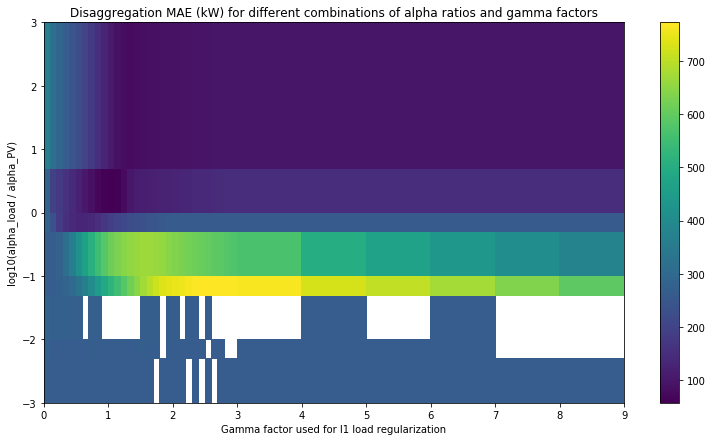

In [19]:
# Varying ratio of (alpha for load) and (alpha for PV) - loss function is l2 for both load and PV
# No regul. for PV, only for load (l1 regularization)

alphaRatioVec = np.load('alphaRatio.npy')
gammaVec = np.load('gamma.npy')
perf = np.load('MAEresults.npy')

alphaGrid = np.log10(np.array(alphaRatioVec))
gammaGrid = np.array(gammaVec)
# alphaGrid = np.log10(np.append(np.array(alphaRatioVec),1000))
# gammaGrid = np.append(np.array(gammaVec),9)
X,Y = np.meshgrid(gammaGrid, alphaGrid)
Z = np.array(perf)

# print(Z)
# print(gammaVec)

plt.pcolormesh(X,Y,Z)
plt.title('Disaggregation MAE (kW) for different combinations of alpha ratios and gamma factors')
plt.xlabel('Gamma factor used for l1 load regularization')
plt.ylabel('log10(alpha_load / alpha_PV)')
plt.colorbar()
# plt.grid(True, color="crimson")
fig = plt.gcf()
fig.set_size_inches(13, 7)
plt.show()

